In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics

import transformers
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import Trainer,TrainingArguments
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import Trainer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt
import pickle
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# TASK B

In [59]:
train= pd.read_csv("/kaggle/input/sarcasm-detection/train.En.csv")
print(train.shape)

(3468, 10)


In [60]:
train.dropna(subset=['tweet'], inplace=True)

In [61]:
train['tweet'].isna().sum()

0

### Obtention des embeddings de Bert

In [39]:
from transformers import BertTokenizer, BertModel
from torch import nn
from transformers import Trainer,TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import AutoModel, DebertaV2Tokenizer

def bert(train_tweets, test_tweets):
        # Initialize the BERT tokenizer
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', num_labels=2,
                                                loss_function_params={"weight": [0.75, 0.25]})
        
        # Tokenize the input tweets and pad/truncate them to a maximum length of 512 tokens
        train_encodings = tokenizer(train_tweets, padding=True, truncation=True, max_length=512)
        test_encodings = tokenizer(test_tweets, padding=True, truncation=True, max_length=512)


        # Convert the encodings to tensors
        input_ids_train = torch.tensor(train_encodings['input_ids'])
        attention_mask_train = torch.tensor(train_encodings['attention_mask'])
        input_ids_test = torch.tensor(test_encodings['input_ids'])
        attention_mask_test = torch.tensor(test_encodings['attention_mask'])

        # Load the pre-trained BERT model
        model = BertModel.from_pretrained('bert-base-uncased')

        # Pass the tokenized input through the model
        with torch.no_grad():
            outputs_train = model(input_ids=input_ids_train, attention_mask=attention_mask_train)
            outputs_test = model(input_ids=input_ids_test, attention_mask=attention_mask_test)

        # Extract the embeddings from the model's output
        embeddings_train = outputs_train.last_hidden_state
        embeddings_test = outputs_test.last_hidden_state

        return tokenizer, embeddings_train, embeddings_test

In [41]:
test = pd.read_csv("/kaggle/input/sarcasm-detection/task_A_En_test.csv")
test

,text,sarcastic
0,"Size on the the Toulouse team, That pack is mo...",0
1,Pinball!,0
2,So the Scottish Government want people to get ...,1
3,villainous pro tip : change the device name on...,0
4,I would date any of these men 🥺,0
...,...,...
1395,I’ve just seen this and felt it deserved a Ret...,0
1396,Omg how an earth is that a pen !!! 🤡,0
1397,Bringing Kanye and drake to a tl near you,0
1398,"I love it when women are referred to as ""girl ...",1


In [42]:
train_tweets = train['tweet'].values.tolist()
train_labels = train['sarcastic'].values.tolist()
test_tweets = test['text'].values.tolist()
test_labels = test['sarcastic'].values.tolist()

In [44]:
tokenizer, train_embeddings, test_embeddings = bert(train_tweets, test_tweets)

In [45]:
# Convertir les tensors d'embeddings en tableaux numpy
embeddings_train_np = train_embeddings.view(train_embeddings.size(0), -1).numpy()
# Créer une liste pour stocker les données
df1 = []
# Itérer sur chaque embedding et son label correspondant
for emb, label in zip(embeddings_train_np, train_labels):
    # Ajouter une nouvelle ligne avec l'embedding et le label correspondant
    df1.append({'tweet_embedding': emb, 'label': label})
# Créer le DataFrame à partir de la liste de dictionnaires
trainset = pd.DataFrame(df1)
# Vérifier la forme du DataFrame
print(trainset.shape)
trainset.head()

(3467, 2)


,tweet_embedding,label
0,"[0.19620167, 0.27427486, -0.12497724, -0.27851...",1
1,"[0.4314823, 0.42537883, 0.24392822, -0.3590437...",1
2,"[0.45887697, 0.07722696, -0.10633854, 0.145102...",1
3,"[0.054374322, 0.16270761, 0.12705112, -0.06395...",1
4,"[-0.015105082, 0.4109176, -0.044817008, 0.0373...",1


## preparation des donnees

In [71]:
df = train[['tweet','sarcasm','irony','satire','understatement','overstatement','rhetorical_question']]

In [72]:
df

,tweet,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,The only thing I got from college is a caffein...,0.0,1.0,0.0,0.0,0.0,0.0
1,I love it when professors draw a big question ...,1.0,0.0,0.0,0.0,0.0,0.0
2,Remember the hundred emails from companies whe...,0.0,1.0,0.0,0.0,0.0,0.0
3,Today my pop-pop told me I was not “forced” to...,1.0,0.0,0.0,0.0,0.0,0.0
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
3463,The population spike in Chicago in 9 months is...,NaN,NaN,NaN,NaN,NaN,NaN
3464,You'd think in the second to last English clas...,NaN,NaN,NaN,NaN,NaN,NaN
3465,I’m finally surfacing after a holiday to Scotl...,NaN,NaN,NaN,NaN,NaN,NaN
3466,Couldn't be prouder today. Well done to every ...,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
trainset

,tweet_embedding,label
0,"[0.19620167, 0.27427486, -0.12497724, -0.27851...",1
1,"[0.4314823, 0.42537883, 0.24392822, -0.3590437...",1
2,"[0.45887697, 0.07722696, -0.10633854, 0.145102...",1
3,"[0.054374322, 0.16270761, 0.12705112, -0.06395...",1
4,"[-0.015105082, 0.4109176, -0.044817008, 0.0373...",1
...,...,...
3462,"[0.17678487, -0.047839645, 0.25036606, -0.0831...",0
3463,"[0.26493683, 0.28706124, -0.35916415, -0.27260...",0
3464,"[-0.003417347, -0.20984395, 0.22559112, -0.539...",0
3465,"[-0.037949387, -0.21413586, 0.20614852, -0.175...",0


In [80]:
newdf = pd.concat([trainset["tweet_embedding"],df[['sarcasm','irony','satire','understatement','overstatement','rhetorical_question']]], axis=1)

In [81]:
newdf

,tweet_embedding,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,"[0.19620167, 0.27427486, -0.12497724, -0.27851...",0.0,1.0,0.0,0.0,0.0,0.0
1,"[0.4314823, 0.42537883, 0.24392822, -0.3590437...",1.0,0.0,0.0,0.0,0.0,0.0
2,"[0.45887697, 0.07722696, -0.10633854, 0.145102...",0.0,1.0,0.0,0.0,0.0,0.0
3,"[0.054374322, 0.16270761, 0.12705112, -0.06395...",1.0,0.0,0.0,0.0,0.0,0.0
4,"[-0.015105082, 0.4109176, -0.044817008, 0.0373...",1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
3463,"[0.26493683, 0.28706124, -0.35916415, -0.27260...",NaN,NaN,NaN,NaN,NaN,NaN
3464,"[-0.003417347, -0.20984395, 0.22559112, -0.539...",NaN,NaN,NaN,NaN,NaN,NaN
3465,"[-0.037949387, -0.21413586, 0.20614852, -0.175...",NaN,NaN,NaN,NaN,NaN,NaN
3466,"[0.17316444, 0.00942028, 0.5548433, -0.0170429...",NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
newdf = newdf.dropna()
newdf = newdf.reset_index(drop = True)
newdf

,tweet_embedding,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,"[0.19620167, 0.27427486, -0.12497724, -0.27851...",0.0,1.0,0.0,0.0,0.0,0.0
1,"[0.4314823, 0.42537883, 0.24392822, -0.3590437...",1.0,0.0,0.0,0.0,0.0,0.0
2,"[0.45887697, 0.07722696, -0.10633854, 0.145102...",0.0,1.0,0.0,0.0,0.0,0.0
3,"[0.054374322, 0.16270761, 0.12705112, -0.06395...",1.0,0.0,0.0,0.0,0.0,0.0
4,"[-0.015105082, 0.4109176, -0.044817008, 0.0373...",1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
862,"[0.042694278, 0.28696677, 0.13154635, -0.12147...",1.0,0.0,0.0,0.0,0.0,1.0
863,"[-0.13148308, 0.085815996, 0.23147838, -0.2539...",1.0,0.0,0.0,0.0,0.0,1.0
864,"[0.38188905, -0.022620806, -0.15177612, -0.086...",0.0,1.0,0.0,0.0,0.0,0.0
865,"[0.21844749, -0.3984793, -0.07088673, 0.154293...",1.0,0.0,0.0,0.0,0.0,0.0


In [89]:
df_melted = pd.melt(newdf, id_vars=['tweet_embedding'], value_vars=['sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question'], var_name='category', value_name='value')

# Filtrer les lignes où la valeur est 1.0, car cela indique la catégorie active
df_melted = df_melted[df_melted['value'] == 1.0]

# Supprimer la colonne 'value' car elle n'est plus nécessaire
df_melted = df_melted.drop('value', axis=1)

# Renommer la colonne 'category' si nécessaire
df_melted.rename(columns={'category': 'category_name'}, inplace=True)

df_melted.reset_index(drop = True)

df_melted

,tweet_embedding,category_name
1,"[0.4314823, 0.42537883, 0.24392822, -0.3590437...",sarcasm
3,"[0.054374322, 0.16270761, 0.12705112, -0.06395...",sarcasm
4,"[-0.015105082, 0.4109176, -0.044817008, 0.0373...",sarcasm
7,"[-0.27869692, 0.31939417, 0.30761528, -0.71344...",sarcasm
8,"[-0.18095784, -0.2820461, 0.49480957, 0.167509...",sarcasm
...,...,...
5187,"[0.15654793, 0.18364778, 0.059557784, -0.13280...",rhetorical_question
5194,"[0.13905942, -0.01920496, 0.029426834, -0.0493...",rhetorical_question
5195,"[0.033044245, 0.105464295, 0.1315186, -0.23984...",rhetorical_question
5197,"[0.042694278, 0.28696677, 0.13154635, -0.12147...",rhetorical_question


In [90]:
target_mapping = {
    'sarcasm': 0,
    'irony': 1,
    'satire': 2,
    'understatement': 3,
    'overstatement': 4,
    'rhetorical_question': 5
}

# Appliquer le mapping
df_melted['category_name'] = df_melted['category_name'].map(target_mapping)

In [110]:
X = np.array(df_melted['tweet_embedding'].tolist(), dtype=np.float32)
y = np.array(df_melted['category_name'], dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
X_train

array([[ 0.16821772,  0.03308778, -0.11634181, ..., -0.08379351,
        -0.13654253, -0.18546596],
       [ 0.3210809 ,  0.15854144,  0.06700815, ...,  0.23087965,
         0.21148846, -0.3702405 ],
       [ 0.08154248, -0.01922362,  0.1047432 , ...,  0.16918296,
         0.16014515, -0.04929092],
       ...,
       [-0.02222835,  0.5061802 , -0.05233792, ..., -0.23268466,
         0.04546177,  0.17783585],
       [ 0.21638337,  0.01808404, -0.08684637, ...,  0.08150347,
         0.01344071, -0.33489802],
       [ 0.01412205,  0.01153579,  0.1329101 , ..., -0.00706784,
         0.16417462, -0.16774863]], dtype=float32)

## Entrainnement de SVM

In [119]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Entraînement du modèle SVM
svm = SVC(kernel='rbf', C=1, gamma='auto')
svm.fit(X_train_scaled, y_train)

SVC(C=1, gamma='auto')

In [125]:
X_test_scaled = scaler.transform(X_test)
y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score (y_test, y_pred, average='weighted')

print("Exactitude (Accuracy) :", accuracy)
print("F1-score:", f1score)

Exactitude (Accuracy) : 0.3923444976076555
F1-score: 0.4483926421806414


In [127]:
forTest  = pd.read_csv("/kaggle/input/sarcasm-detection/task_B_En_test.csv")
forTest

,text,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,saw a video of someone getting a hug. would LO...,0,0,0,0,0,0
1,"""This Christmas I hope you all either get vacc...",0,0,0,0,0,0
2,It's the alamo,0,0,0,0,0,0
3,"Wind 5 mph E. Barometer 1029.8 hPa, Pressure t...",0,0,0,0,0,0
4,I constantly have loads of the new symptoms bu...,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1395,Tempting to renew my membership and vote again...,0,0,0,0,0,0
1396,This week has felt like the longest in history...,0,0,0,0,0,0
1397,Of course it’s raining when I’m due to go out ...,0,0,0,0,0,0
1398,Weigh up a lie before you tell it.,0,0,0,0,0,0


# Let's See how our Model Deal with Classes

In [272]:
indices0 = df_melted[df_melted["category_name"] == 0].index
indices1 = df_melted[df_melted["category_name"] == 1].index
indices2 = df_melted[df_melted["category_name"] == 2].index
indices3 = df_melted[df_melted["category_name"] == 3].index
indices4 = df_melted[df_melted["category_name"] == 4].index
indices5 = df_melted[df_melted["category_name"] == 5].index


In [273]:
y_pred = clf.predict(df_melted.loc[indices0]['tweet_embedding'].tolist())
f1score_0 = f1_score (df_melted.loc[indices0]['category_name'], y_pred, average='weighted')

y_pred = clf.predict(df_melted.loc[indices1]['tweet_embedding'].tolist())
f1score_1 = f1_score (df_melted.loc[indices1]['category_name'], y_pred, average='weighted')

y_pred = clf.predict(df_melted.loc[indices2]['tweet_embedding'].tolist())
f1score_2 = f1_score (df_melted.loc[indices2]['category_name'], y_pred, average='weighted')

y_pred = clf.predict(df_melted.loc[indices3]['tweet_embedding'].tolist())
f1score_3 = f1_score (df_melted.loc[indices3]['category_name'], y_pred, average='weighted')

y_pred = clf.predict(df_melted.loc[indices4]['tweet_embedding'].tolist())
f1score_4 = f1_score (df_melted.loc[indices4]['category_name'], y_pred, average='weighted')

y_pred = clf.predict(df_melted.loc[indices5]['tweet_embedding'].tolist())
f1score_5 = f1_score (df_melted.loc[indices5]['category_name'], y_pred, average='weighted')

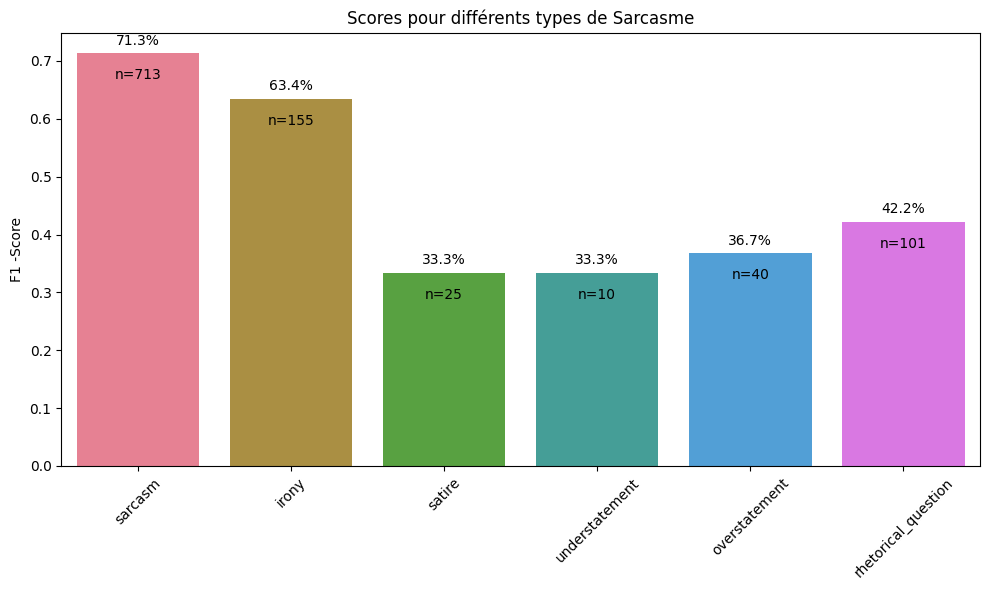

In [274]:

y = [f1score_0, f1score_1, f1score_2, f1score_3, f1score_4, f1score_5]
nbre_donnes = [len(indices0), len(indices1), len(indices2), len(indices3), len(indices4), len(indices5)]
x = ['sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']

# Palette de couleurs de seaborn
palette = sns.color_palette("husl", len(x))

# Création du barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=x, y=y, palette=palette)
plt.ylabel('F1 -Score')
plt.title('Scores pour différents types de Sarcasme')
plt.xticks(rotation=45)

# Ajouter les pourcentages au-dessus de chaque barre
for i, (v, n) in enumerate(zip(y, nbre_donnes)):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center', va='bottom')
    plt.text(i, v - 0.05, f"n={n}", ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()
